In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
import os

from monodepthloss import MonodepthLoss
from depthnet import *

#from depthencoder import depthencoder 
#from depth_decoder import *

DEVICE = torch.device("cuda:0")

In [2]:
encoderdecoder = ResnetModel(3).to(DEVICE)

optimizer = optim.Adam(encoderdecoder.parameters(),lr=0.001)
loss_function = MonodepthLoss(n=4, SSIM_w=0.85,\
                disp_gradient_w=0.1, lr_w=1).to(DEVICE)

encoderdecoder.load_state_dict(torch.load('encoderdecoder-1573856141'))
data = []
directory = "numpy_img/"
for file in os.listdir(directory):
    training_data = np.load(directory+file, allow_pickle=True, mmap_mode = 'r+')
    data.append(training_data)

In [3]:
testing = False
j = 0
mean = []
n = 3
epochs = 10

f= open(f"logs/results-{int(time.time())}.txt","w+")
for epoch in range(epochs):
    samps = []
    print("Epoch: "+ str(epoch))
    for img, training_data in enumerate(data):
        nums = list(range(len(training_data)))
        for i in range(0, len(nums), n):
            samps.append([img, nums[i:i+n]])
    random.shuffle(samps)
    for frame in tqdm(samps):
        LinNimg = torch.from_numpy(data[frame[0]][frame[1],0])\
        .type(torch.cuda.FloatTensor)
        RoutNimg = torch.from_numpy(data[frame[0]][frame[1],1])\
        .type(torch.cuda.FloatTensor)

        LinN = torch.div(LinNimg, 255).permute(0,3,1,2)
        RoutN = torch.div(RoutNimg, 255).permute(0,3,1,2)

        encoderdecoder.zero_grad()
        output = encoderdecoder(LinN.view(-1,3,256,640))
        loss = loss_function(output,[LinN.view(-1,3,256,640),RoutN.view(-1,3,256,640)])
        loss.backward()
        mean.append(loss.item())
        j += 1
        if j % 100 == 0:
            f.write(f"{round(sum(mean)/len(mean),5)}\n")
            f.flush()
            mean = []
        if j % 5000 == 0:
            thetime = int(time.time())
            torch.save(encoderdecoder.state_dict(), f"encoderdecoder-{thetime}")
            save_image(RoutN[1,:,:,:].view(3,256,640).cpu(), \
                       f'imageout/{thetime}-left.png')
            save_image(output[0][1,0,:,:].view(256,640).cpu(), \
                       f'imageout/{thetime}-depth.png')
        optimizer.step()
f.close()

  0%|          | 0/45080 [00:00<?, ?it/s]

Epoch: 0


 40%|███▉      | 17899/45080 [1:25:05<3:00:21,  2.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 55%|█████▍    | 24700/45080 [1:58:09<1:45:55,  3.21it/s]

KeyboardInterrupt: 

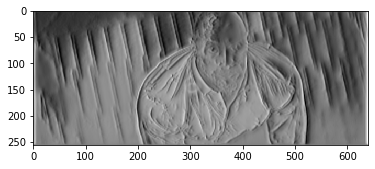

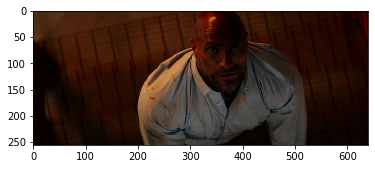

In [8]:
plt.imshow(output[0][0,0,:,:].view(256, 640).cpu().detach().numpy(), 'gray')
plt.show()
plt.imshow(RoutN[0,:,:,:].view(3,256,640).permute(1,2,0).cpu())
plt.show()

In [5]:
output[0][1,0,:,:]

tensor([[ 1.6190e-04, -2.3142e-03, -5.1089e-03,  ...,  9.8240e-05,
          1.0084e-03,  1.7463e-03],
        [ 2.9656e-03, -1.0843e-03, -5.0293e-03,  ...,  3.6274e-03,
          5.6825e-03,  7.2121e-03],
        [ 3.7750e-03, -1.6539e-03, -5.5161e-03,  ...,  4.5657e-03,
          6.7515e-03,  8.0521e-03],
        ...,
        [ 2.9134e-03,  3.7147e-03,  4.3189e-03,  ...,  2.8525e-03,
          6.2652e-03,  8.6895e-03],
        [ 2.9398e-03,  2.3875e-03,  2.9670e-03,  ...,  1.4538e-03,
          4.3078e-03,  6.8093e-03],
        [ 1.1506e-03,  1.0656e-03,  7.9290e-04,  ..., -4.2747e-04,
          1.5867e-03,  3.8324e-03]], device='cuda:0', grad_fn=<SliceBackward>)